In [2]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
print("Checkpoint 1")
import anndata as an
import scanpy as sc
import umap
import gc
from importlib import reload
print("Checkpoint 2")

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

print("Checkpoint 3")

# local imports
import geneformer_utils as gtu

sns.set_style('white')
print("All done!")

Checkpoint 1


/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checkpoint 2
Checkpoint 3
All done!


In [3]:
reload(gtu)
torch.cuda.empty_cache()
num_cells = 1000

"""Load the model"""
#model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
df = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)
df.head()


,input_ids,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,length
0,"[16345, 9009, 13048, 6489, 10292, 9508, 12698,...",Vasculature,10X,TSP14,CoronaryArteries,12027.0,3428,fibroblast,fibroblast,True,stromal,male,2048
1,"[12119, 9190, 16876, 3396, 8654, 5298, 4692, 1...",Vasculature,10X,TSP14,CoronaryArteries,5342.0,2010,fibroblast,fibroblast,True,stromal,male,2048
2,"[5511, 11358, 14120, 6128, 2348, 1720, 2411, 2...",Vasculature,10X,TSP2,Aorta,7725.0,2682,macrophage,macrophage,True,immune,female,2048
3,"[2411, 1513, 21227, 14120, 1720, 8981, 2124, 7...",Vasculature,10X,TSP14,AortaVeneCava,13593.0,3679,macrophage,macrophage,True,immune,male,2048
4,"[3878, 9009, 4115, 1950, 376, 16281, 16916, 14...",Vasculature,10X,TSP14,CoronaryArteries,10892.0,3730,fibroblast,fibroblast,True,stromal,male,2048


In [4]:
# # convert into arrow dataset
# data = Dataset.from_pandas(df)

# # useful for later
# features = df.columns.to_list()
# features.remove("input_ids")

# print(f"{df.shape=}")
# df.head()
df["cell_ontology_class"]
df["free_annotation"]

# just me making sure that cell_ontology_class and free_annotation are equal (they are)
#faster way?
for index, row in df.loc[:, ['cell_ontology_class', 'free_annotation']].iterrows():
    if (row['cell_ontology_class'] != row['free_annotation']):
        print("unequal")
print("done!")

done!


In [5]:
# Lookin for fibroblast guys to filter and safe that as filtered_df
def search_string(s, search):
    return search in str(s).lower()

mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'fibroblast')))

filtered_df = df.loc[mask.any(axis=1)]

print(filtered_df)
filtered_df.shape


                                             input_ids organ_tissue  \
0    [16345, 9009, 13048, 6489, 10292, 9508, 12698,...  Vasculature   
1    [12119, 9190, 16876, 3396, 8654, 5298, 4692, 1...  Vasculature   
4    [3878, 9009, 4115, 1950, 376, 16281, 16916, 14...  Vasculature   
6    [3878, 16916, 18367, 9009, 1950, 12119, 16876,...  Vasculature   
7    [6196, 16916, 10920, 11828, 8133, 16166, 8163,...  Vasculature   
..                                                 ...          ...   
984  [12119, 18367, 16876, 9123, 303, 6541, 10057, ...  Vasculature   
985  [376, 3878, 12119, 5592, 15960, 16916, 16281, ...  Vasculature   
988  [9009, 12119, 16916, 8658, 16876, 3878, 15960,...  Vasculature   
996  [2649, 5592, 2124, 16166, 7414, 376, 454, 220,...  Vasculature   
998  [12119, 4840, 15960, 19437, 2649, 6252, 5080, ...  Vasculature   

        method  donor anatomical_information  n_counts_UMIs  n_genes  \
0          10X  TSP14       CoronaryArteries        12027.0     3428   
1  

(354, 13)

In [6]:
# convert filtered stuff to df
filtered_dataset = Dataset.from_pandas(filtered_df)
filtered_dataset.save_to_disk("/home/oliven/geneformer_dev/notebooks/ts_output")
loaded_dataset = Dataset.load_from_disk("/home/oliven/geneformer_dev/notebooks/ts_output")

Saving the dataset (1/1 shards): 100%|██████████| 354/354 [00:00<00:00, 19503.52 examples/s]


In [8]:
# Extract the embedding
mem_embs = gtu.extract_embedding_in_mem(model, loaded_dataset)
#embs.head()
mem_embs.shape
# 354 x 512 is promising that the filtering was done right
# i checked and it's a df

# save to ts_output folder
mem_embs.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/mem_embs.csv')


100%|██████████| 36/36 [00:15<00:00,  2.37it/s]


In [1]:
# takes embeddings into anndata, puts metadata into obs
adata = gtu.embedding_to_adata(mem_embs)
adata.obs = loaded_dataset.to_pandas().copy()
adata

NameError: name 'gtu' is not defined

In [9]:
# initiate EmbExtractor but dont actually get the embeddings just use the ones you already have
membex = EmbExtractor(model_type="CellClassifier",
                     num_classes=3,

                     max_ncells=1000,
                     emb_layer=-1,
                     emb_label=["compartment","gender"],
                     labels_to_plot=["compartment", "gender"],
                     forward_batch_size=30,
                     nproc=4)
membex.plot_embs(embs=mem_embs, 
                plot_style="umap",
                output_directory='/home/oliven/geneformer_dev/notebooks/ts_output/',  
                output_prefix="mem_emb_plot")

#                      filter_data={"cell_type":["Cardiomyocyte1","Cardiomyocyte2","Cardiomyocyte3"]},

Label compartment from labels_to_plot not present in provided embeddings dataframe.
Label gender from labels_to_plot not present in provided embeddings dataframe.


In [ ]:
# alternative way to extract the embedding

# # model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
# # data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
# # data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_muscle.dataset"
# data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
# outpath = "/home/oliven/geneformer_dev/notebooks/ts_output/"


# torch.cuda.empty_cache()

# n_cells = 1000
# # 0 for last layer, -1 for second to last
# layer = -1

# # initiate EmbExtractor
# embex = EmbExtractor(model_type="Pretrained",
#                      num_classes=0,
#                      max_ncells=n_cells,
#                      emb_mode='cell',
#                      emb_layer=layer,
#                      emb_label=["cell_type",],
#                      forward_batch_size=30,
#                      nproc=16,
#                       )

# # # extracts embedding from input data
# # embs = embex.extract_embs(model,
# #                           data_path,
# #                           outpath,
# #                           "test")

# embs.head()

/tmp/ipykernel_290376/1513053456.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral')


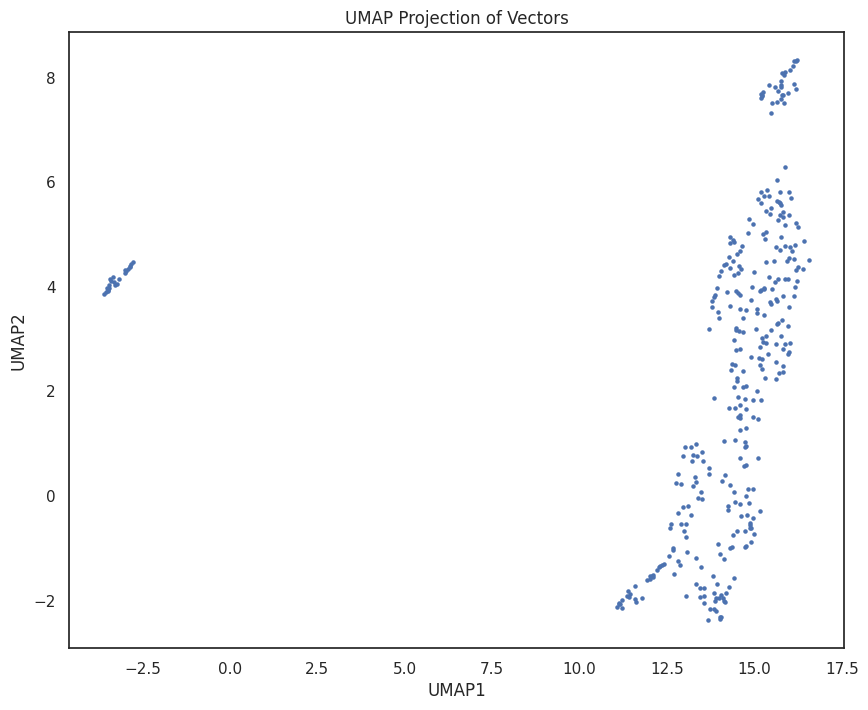

In [10]:
#newer
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/home/oliven/geneformer_dev/notebooks/ts_output/mem_embs.csv'  # Update this path to the location of your file
data = pd.read_csv(file_path)

# Drop the unnamed index column
data_vectors = data.drop(columns=['Unnamed: 0'])

# Create a UMAP reducer object
reducer = umap.UMAP()

# Fit and transform the data
embedding = reducer.fit_transform(data_vectors)

# Plotting the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral')
plt.title('UMAP Projection of Vectors')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()



#this is all fine and dandy but i don't have any of the metadata that was in the original file I extracted this from.  what's the best way to do this?

In [1]:


#this is all fine and dandy but i don't have any of the metadata that was in the original file I extracted this from.  what's the best way to do this?

KeyboardInterrupt: 

In [ ]:
break

### Perturbation I would hope

In [16]:
cell_states_to_model={"state_key": "cell_ontology_class"}
#is this where you would add on entries for pre and post-embeddings?  they don't exist yet as cols in the data so im gonna leave it

embex = EmbExtractor(model_type="Pretrained",
                     num_classes=3,
                     max_ncells=1000,
                     emb_layer=0,
                     summary_stat="exact_mean",
                     forward_batch_size=20,
                     nproc=1)


model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
outpath = "/home/oliven/geneformer_dev/notebooks/ts_output/"

state_embs_dict = embex.get_state_embs(cell_states_to_model,
                                       model,
                                       data_path,
                                       outpath,
                                       "preturb")

print('done')

The single value dictionary for cell_states_to_model will be replaced with a dictionary with named keys for start, goal, and alternate states. Please specify state_key, start_state, goal_state, and alt_states in the cell_states_to_model dictionary for future use. For example, cell_states_to_model={'state_key': 'disease', 'start_state': 'dcm', 'goal_state': 'nf', 'alt_states': ['hcm', 'other1', 'other2']}


done


In [ ]:

genes = [
    'ENSG00000162924', # GATA2 
    'ENSG00000179348', # GFI1B
    'ENSG00000165702', # FOS
    'ENSG00000170345', # STAT5A
    'ENSG00000126561', # REL
]

isp = InSilicoPerturber(perturb_type="overexpress",
                        perturb_rank_shift=None,
                        genes_to_perturb=genes,
                        combos=0, # individually, or in pairs `1'
                        anchor_gene=None,
                        model_type="Pretrained",
                        num_classes=0, # pretrained model
                        emb_mode="cell",
                        cell_emb_style="mean_pool",
                        cell_states_to_model=cell_states_to_model,
                        state_embs_dict=state_embs_dict,
                        max_ncells=1000,
                        emb_layer=-1,
                        forward_batch_size=10,
                        nproc=1)

### Get prettier metadata attempts

In [8]:
#repeat prelims
reload(gtu)
torch.cuda.empty_cache()
num_cells = 1000

"""Load the model"""
#model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
df_itrue = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)
df_itrue.head()

,input_ids,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,length
0,"[16345, 9009, 13048, 6489, 10292, 9508, 12698,...",Vasculature,10X,TSP14,CoronaryArteries,12027.0,3428,fibroblast,fibroblast,True,stromal,male,2048
1,"[12119, 9190, 16876, 3396, 8654, 5298, 4692, 1...",Vasculature,10X,TSP14,CoronaryArteries,5342.0,2010,fibroblast,fibroblast,True,stromal,male,2048
2,"[5511, 11358, 14120, 6128, 2348, 1720, 2411, 2...",Vasculature,10X,TSP2,Aorta,7725.0,2682,macrophage,macrophage,True,immune,female,2048
3,"[2411, 1513, 21227, 14120, 1720, 8981, 2124, 7...",Vasculature,10X,TSP14,AortaVeneCava,13593.0,3679,macrophage,macrophage,True,immune,male,2048
4,"[3878, 9009, 4115, 1950, 376, 16281, 16916, 14...",Vasculature,10X,TSP14,CoronaryArteries,10892.0,3730,fibroblast,fibroblast,True,stromal,male,2048


In [9]:
#second part prelims 
def search_string(s, search):
    return search in str(s).lower()

mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'fibroblast')))

filtered_df_itrue = df.loc[mask.any(axis=1)]

print(filtered_df_itrue)
filtered_df_itrue.shape


                                             input_ids organ_tissue  \
0    [16345, 9009, 13048, 6489, 10292, 9508, 12698,...  Vasculature   
1    [12119, 9190, 16876, 3396, 8654, 5298, 4692, 1...  Vasculature   
4    [3878, 9009, 4115, 1950, 376, 16281, 16916, 14...  Vasculature   
6    [3878, 16916, 18367, 9009, 1950, 12119, 16876,...  Vasculature   
7    [6196, 16916, 10920, 11828, 8133, 16166, 8163,...  Vasculature   
..                                                 ...          ...   
984  [12119, 18367, 16876, 9123, 303, 6541, 10057, ...  Vasculature   
985  [376, 3878, 12119, 5592, 15960, 16916, 16281, ...  Vasculature   
988  [9009, 12119, 16916, 8658, 16876, 3878, 15960,...  Vasculature   
996  [2649, 5592, 2124, 16166, 7414, 376, 454, 220,...  Vasculature   
998  [12119, 4840, 15960, 19437, 2649, 6252, 5080, ...  Vasculature   

        method  donor anatomical_information  n_counts_UMIs  n_genes  \
0          10X  TSP14       CoronaryArteries        12027.0     3428   
1  

(354, 13)

In [18]:
#third pt prelims
# convert filtered stuff to df
filtered_dataset_itrue = Dataset.from_pandas(filtered_df_itrue)
filtered_dataset_itrue.save_to_disk("/home/oliven/geneformer_dev/notebooks/ts_output")
loaded_dataset_itrue = Dataset.load_from_disk("/home/oliven/geneformer_dev/notebooks/ts_output")

mem_embs_itrue = gtu.extract_embedding_in_mem(model, loaded_dataset_itrue)
print(f"{mem_embs_itrue.shape=}")
mem_embs.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/mem_embs_itrue.csv')

100%|██████████| 36/36 [00:09<00:00,  3.78it/s]


mem_embs_itrue.shape=(354, 512)


In [21]:
# Assuming mem_embs is a DataFrame with the extracted embeddings for the fibroblast cells
# and df is the original DataFrame.

# Ensure mem_embs is indexed in the same order as filtered_df
filtered_df_itrue.reset_index(drop=True, inplace=True)
mem_embs_itrue.reset_index(drop=True, inplace=True)

# Add the embeddings to the filtered dataframe
filtered_df_itrue['embeddings'] = mem_embs_itrue.values.tolist()

# Merge the filtered_df with embeddings back to the original df
df_itrue['embeddings'] = np.nan  # Initialize the new column with NaN
df.loc_itrue[filtered_df.index, 'embeddings'] = filtered_df['embeddings']

# Save the fibroblast_df as a separate object
fibroblast_df_itrue = filtered_df_itrue.copy()

# Save the original dataframe with embeddings to a new CSV or any other desired format
df_itrue.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/original_df_with_embeddings_itrue.csv', index=True)

# Save the fibroblast_df as a separate CSV or any other desired format
fibroblast_df_itrue.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/fibroblast_df_itrue.csv', index=True)

/tmp/ipykernel_3370336/2594092092.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_itrue['embeddings'] = mem_embs_itrue.values.tolist()


KeyError: 'embeddings'

In [23]:


# Assuming mem_embs is a DataFrame with the extracted embeddings for the fibroblast cells
# and df is the original DataFrame.

# Ensure mem_embs is indexed in the same order as filtered_df
filtered_df.reset_index(drop=True, inplace=True)
mem_embs.reset_index(drop=True, inplace=True)

# Create a new column in the original dataframe and fill it with NaN
df['embeddings'] = np.nan

# Iterate over the filtered_df to set the embeddings in the original df
for idx in filtered_df.index:
    df.at[idx, 'embeddings'] = mem_embs.loc[idx].tolist()

# Save the original dataframe with embeddings to a new CSV or any other desired format
df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/original_df_with_embeddings.csv', index=False)

# Save the fibroblast_df as a separate CSV or any other desired format
fibroblast_df = filtered_df.copy()
fibroblast_df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/fibroblast_df.csv', index=False)

ValueError: Must have equal len keys and value when setting with an iterable

In [25]:
import pandas as pd
import numpy as np

# Assuming mem_embs is a DataFrame with the extracted embeddings for the fibroblast cells
# and df is the original DataFrame.

# Ensure mem_embs is indexed in the same order as filtered_df
filtered_df.reset_index(drop=True, inplace=True)
mem_embs.reset_index(drop=True, inplace=True)

# Create a new column in the original dataframe and fill it with NaN
df['embeddings'] = np.nan

# Convert the NaN values to a suitable format for holding lists
df['embeddings'] = df['embeddings'].apply(lambda x: [np.nan]*mem_embs.shape[1])

# Iterate over the filtered_df to set the embeddings in the original df
for original_idx, filtered_idx in zip(filtered_df.index, mem_embs.index):
    df.at[original_idx, 'embeddings'] = mem_embs.loc[filtered_idx].tolist()

# Save the original dataframe with embeddings to a new CSV or any other desired format
df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/original_df_with_embeddings.csv', index=False)

# Save the fibroblast_df as a separate CSV or any other desired format
fibroblast_df = filtered_df.copy()
fibroblast_df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/fibroblast_df.csv', index=False)


In [26]:
import pandas as pd
import numpy as np

# Assuming mem_embs is a DataFrame with the extracted embeddings for the fibroblast cells
# and df is the original DataFrame.

# Initialize a new column in df for embeddings and fill with NaN
df['embeddings'] = np.nan

# Iterate over the filtered_df to set the embeddings in the original df
for idx in filtered_df.index:
    df.loc[idx, 'embeddings'] = mem_embs.loc[idx].values

# Save the original dataframe with embeddings to a new CSV or any other desired format
df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/original_df_with_embeddings.csv', index=False)

# Save the fibroblast_df as a separate CSV or any other desired format
fibroblast_df = filtered_df.copy()
fibroblast_df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/fibroblast_df.csv', index=False)


ValueError: Must have equal len keys and value when setting with an iterable

In [7]:
import pandas as pd
import numpy as np

# Assuming mem_embs is a DataFrame with the extracted embeddings for the fibroblast cells
# and df is the original DataFrame.

# Initialize a new column in df for embeddings and fill with NaN
df['embeddings'] = np.nan

# Convert the NaN values to a suitable format for holding lists
df['embeddings'] = df['embeddings'].apply(lambda x: [np.nan] * mem_embs.shape[1] if pd.isna(x) else x)

# Iterate over the filtered_df to set the embeddings in the original df
for idx in filtered_df.index:
    df.at[idx, 'embeddings'] = mem_embs.loc[idx].values.tolist()

# Save the original dataframe with embeddings to a new CSV or any other desired format
df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/original_df_with_embeddings.csv', index=False)

# Save the fibroblast_df as a separate CSV or any other desired format
fibroblast_df = filtered_df.copy()
fibroblast_df.to_csv('/home/oliven/geneformer_dev/notebooks/ts_output/fibroblast_df.csv', index=False)


KeyError: 354

In [ ]:
# Step 1: Filter rows containing 'fibroblast'
mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'fibroblast')))
filtered_df = df.loc[mask.any(axis=1)]

# Step 2: Apply extract_embedding_in_mem function and save embeddings
def apply_embedding(row):
    if search_string(row, 'fibroblast'):
        return extract_embedding_in_mem(row)
    else:
        return None

filtered_df['embeddings'] = filtered_df.apply(apply_embedding, axis=1)

print(filtered_df)
print(filtered_df.shape)


In [8]:
from datasets import Dataset

# Step 1: Filter rows containing 'fibroblast' in original df
mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'fibroblast')))
filtered_df = df.loc[mask.any(axis=1)]

# Step 2: Function to apply for extracting embeddings
def apply_embedding(row):
    if search_string(row, 'fibroblast'):
        return extract_embedding_in_mem(row)
    else:
        return None

# Apply function to original df to preserve indexes
df['embeddings'] = df.apply(apply_embedding, axis=1)

# Step 3: Convert to Dataset and save to disk
dataset = Dataset.from_pandas(df)
dataset.save_to_disk("/home/oliven/geneformer_dev/notebooks/ts_output")

# Optionally load from disk
loaded_dataset = Dataset.load_from_disk("/home/oliven/geneformer_dev/notebooks/ts_output")


NameError: name 'extract_embedding_in_mem' is not defined

In [ ]:
for index, row in df.iterrows():
    if 'fibroblast' in row['text_column']:
        embeddings = extract_embedding_in_mem(row['text_column'])
        df.at[index, 'embeddings'] = embeddings

In [6]:
# Step 1: Create a mask to filter rows containing 'fibroblast'
mask = df['text_column'].str.contains('fibroblast', case=False, na=False)

# Step 2: Copy the masked DataFrame, preserving the original indexes
filtered_df_2 = df[mask].copy()

# Step 3: Apply the extract_embedding_in_mem function
filtered_df_2 = extract_embedding_in_mem(filtered_df)

# Step 4: Merge the results back into the original DataFrame
df.loc[filtered_df.index, 'embeddings'] = filtered_df['embeddings']

print(df)

KeyError: 'text_column'